In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

from pymc3.gp.util import plot_gp_dist
import cmdstanpy as stan
import arviz as az

from tqdm import tqdm

In [2]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
%load_ext stanmagic

# Utility models

In [4]:
def u_pow(x, theta): return x**theta

In [5]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [6]:
def u_lin(x, theta=None): return x

# Generate choice data

In [7]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

In [8]:
data = generate_data(u=u_pow, n=1000, tau=3.333, theta=(0.5, ))
data

,p0,x0,p1,x1,choices
9002,0.696389,0.007647,0.617248,0.282997,1
7863,0.953285,0.292898,0.380948,0.552913,1
7455,0.060678,0.327938,0.685627,0.158464,1
3414,0.138550,0.276750,0.788651,0.125342,0
5796,0.116159,0.356232,0.732859,0.310642,0
...,...,...,...,...,...
2857,0.928569,0.159319,0.006656,0.571188,0
5417,0.621396,0.103035,0.601608,0.871169,1
1854,0.218694,0.560962,0.389658,0.026879,1
8834,0.980679,0.073375,0.877985,0.777087,1


# Likelihood whole model given M, $\theta_M$

In [9]:
def softplus(x):
    return np.log(1 + np.exp(x))

def objective(param, data, u_m):
    
    param = softplus(param)  # All parameters all supposed to be R+
    
    tau = param[0]
    theta = param[1]
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, theta)
    seu1 = p1 * u_m(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [10]:
def optimize(data, u_m=u_pow, x0=None):
    if x0 is None:
        x0 = (0.0, 0.0) # Assume two parameters
    opt = scipy.optimize.minimize(objective, x0=x0, args=(data, u_m))
    return softplus(opt.x)

In [11]:
optimize(data, u_m=u_pow)

array([3.28496491, 0.53506426])

# Measure discrepancy

## Define model

In [56]:
%%stan -f gp_model_additive.stan -v gp_model --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
data {
  int<lower=0> N;
  int<lower=0> N_y;
  vector<lower=0, upper=1>[N] p;
  vector[N] X;
  int<lower=0, upper=1> y[N_y];
  int belong0[N_y];
  int belong1[N_y];
  real tau;
  real jitter;
  vector[N] mu;
}
transformed data {
  matrix[N, N] diag_jitter;
  real X_array[N];
  diag_jitter = diag_matrix(rep_vector(jitter, N));
  X_array = to_array_1d(X);
}
parameters {
  real<lower=0> kernel_length;
  real<lower=0> kernel_var; 
  vector[N] eta;
}
transformed parameters{
}
model {
  vector[N] seu;
  vector[N_y] seu0;
  vector[N_y] seu1;
  vector[N_y] diff_eu;
  matrix[N, N] L;
  matrix[N, N] K;
  vector[N] f;
  
  kernel_length ~ normal(1, 1);
  kernel_var ~ normal(1, 1);
  eta ~ std_normal();
  
  K = gp_exp_quad_cov(X_array, kernel_var, kernel_length) + diag_jitter;
  L = cholesky_decompose(K);
  
  f = mu + L*eta;
  
  seu = p .* f;
  seu0 = seu[belong0];
  seu1 = seu[belong1];
  diff_eu = seu1 - seu0;
  y ~ bernoulli_logit(tau * diff_eu);
}
generated quantities {
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/a09e7277-09cb-4535-b5c0-23afe3ca09ce.cpp gp_model_additive.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in gp_model object.
Type gp_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^
Access model compile output properties
gp_model.model_file -> Name of stan_file [gp_model_additive.stan]
gp_model.model_name -> Name of stan model [gp_model_additive_model]
gp_model.model_code -> Model code [data {   int<lower=0 ....]


In [57]:
stan_model = stan.CmdStanModel(stan_file=gp_model.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/gp_model_additive
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/gp_model_additive


In [58]:
def prepare_data_for_stan(data, u, theta, tau):
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    # mu = x_sorted
    # kernel_factor = x_sorted*x_sorted[:, None]
    mu = u(x_sorted, theta)
    kernel_factor = mu*mu[:, None]
    
    N = len(x)
    N_y = len(y)
    belong0 = undo_sorted[:N_y]
    belong1 = undo_sorted[N_y:]
    
    assert kernel_factor.shape == (N, N)

    return {
        ''
        'tau': tau,
        'p': p_sorted,
        'X': x_sorted,
        'y': y,
        'N_y': N_y,
        'N': N,
        'jitter': 1e-06,
        'belong0': belong0 + 1,
        'belong1': belong1 + 1,
        'mu': mu,
        'kernel_factor': kernel_factor
    } 

## With 'bad' prior

In [59]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333
data = generate_data(u=u_data, theta=theta_data, tau=tau_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(100, replace=False)

In [60]:
optimize(data)

array([3.4444072 , 0.39557323])

In [61]:
u_model = u_lin # u_data
theta_model = None # theta_data
tau_model = 3.333

In [62]:
stan_data = prepare_data_for_stan(data, u=u_model, theta=theta_model, tau=tau_model)

In [63]:
trace = stan_model.sample(data=stan_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
samples_az = az.from_cmdstanpy(trace)

### Make predictions

In [65]:
def kernel(X, Xs, length):
    deltaX = np.power((X[:, None] - Xs) / length, 2.0)
    return np.exp(-0.5 * deltaX)

def gp_predict(X, samples_az, u, theta, Xnew=None, jitter=1.0e-6):
    
    n_sample = samples_az.posterior["kernel_var"].shape[0] * samples_az.posterior["kernel_var"].shape[1]
    
    var_samples = np.array(samples_az.posterior["kernel_var"]).reshape(n_sample, -1)
    length_samples = np.array(samples_az.posterior["kernel_length"]).reshape(n_sample, -1)
    eta_samples = np.array(samples_az.posterior["eta"]).reshape(n_sample, -1)
    
    N = X.shape[0]
    
    if Xnew is not None:
        f_predict = np.zeros((n_sample, Xnew.shape[0]))

    else:
        f_predict = np.zeros((n_sample, N))
        
    uX = u(X, theta_model)
    
    for i in tqdm(range(n_sample)):
    
        var=var_samples[i]
        length=length_samples[i]
        eta=eta_samples[i] 

        k_XX = var**2 * kernel(X, X, length) + jitter*np.eye(N)
        L = np.linalg.cholesky(k_XX)
        L_eta = L.dot(eta)

        if Xnew is not None:

            up = u(Xnew, theta)
            
            K_Xp = var**2 * kernel(X, Xnew, length)

            A = scipy.linalg.solve_triangular(L, K_Xp, lower=True)
            v = scipy.linalg.solve_triangular(L, L_eta, lower=True)
            
            f_predict[i] = up + A.T.dot(v)

        else:
            f = uX + L_eta
            f_predict[i] = f
    
    return f_predict

In [66]:
f_samples = gp_predict(X=stan_data["X"], samples_az=samples_az, 
                       u=u_model, theta=theta_model, Xnew=None)

100%|██████████| 2000/2000 [00:02<00:00, 675.80it/s]


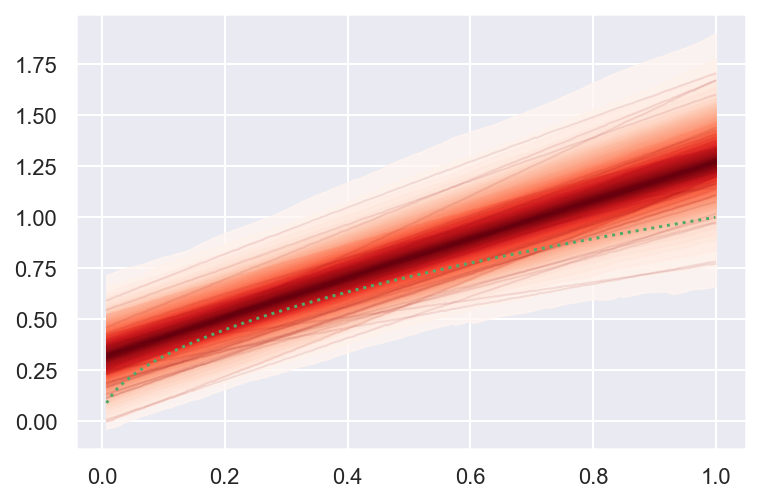

In [67]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, stan_data["X"])
# ax.plot(X, u_model(X, theta=theta_model), ls="--");
ax.plot(stan_data["X"], u_data(stan_data["X"], theta=theta_data), ls=':', color="C2");

In [68]:
x_plot = np.linspace(0, 1, 100)
f_samples = gp_predict(X=stan_data["X"], samples_az=samples_az, 
                       u=u_model, theta=theta_model,
                       Xnew=x_plot)

100%|██████████| 2000/2000 [00:05<00:00, 383.36it/s]


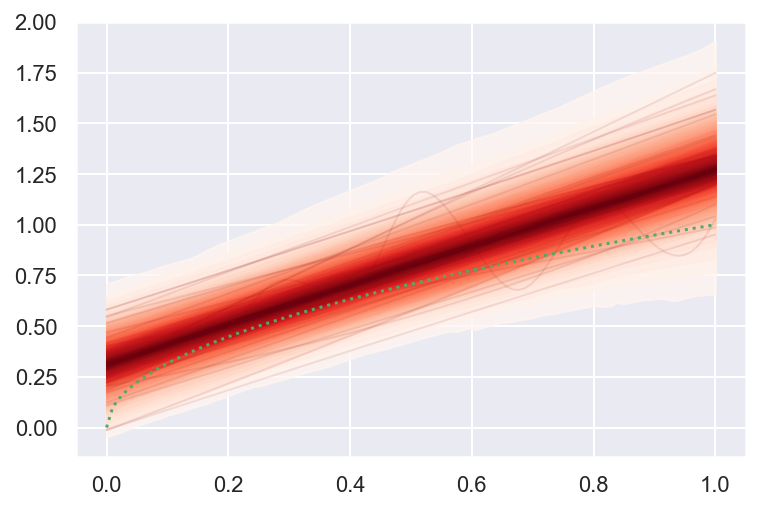

In [69]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, x_plot)
# ax.plot(X, u_model(X, theta=theta_model), ls="--");
ax.plot(x_plot, u_data(x_plot, theta=theta_data), ls=':', color="C2");

### Posterior kernel parameters

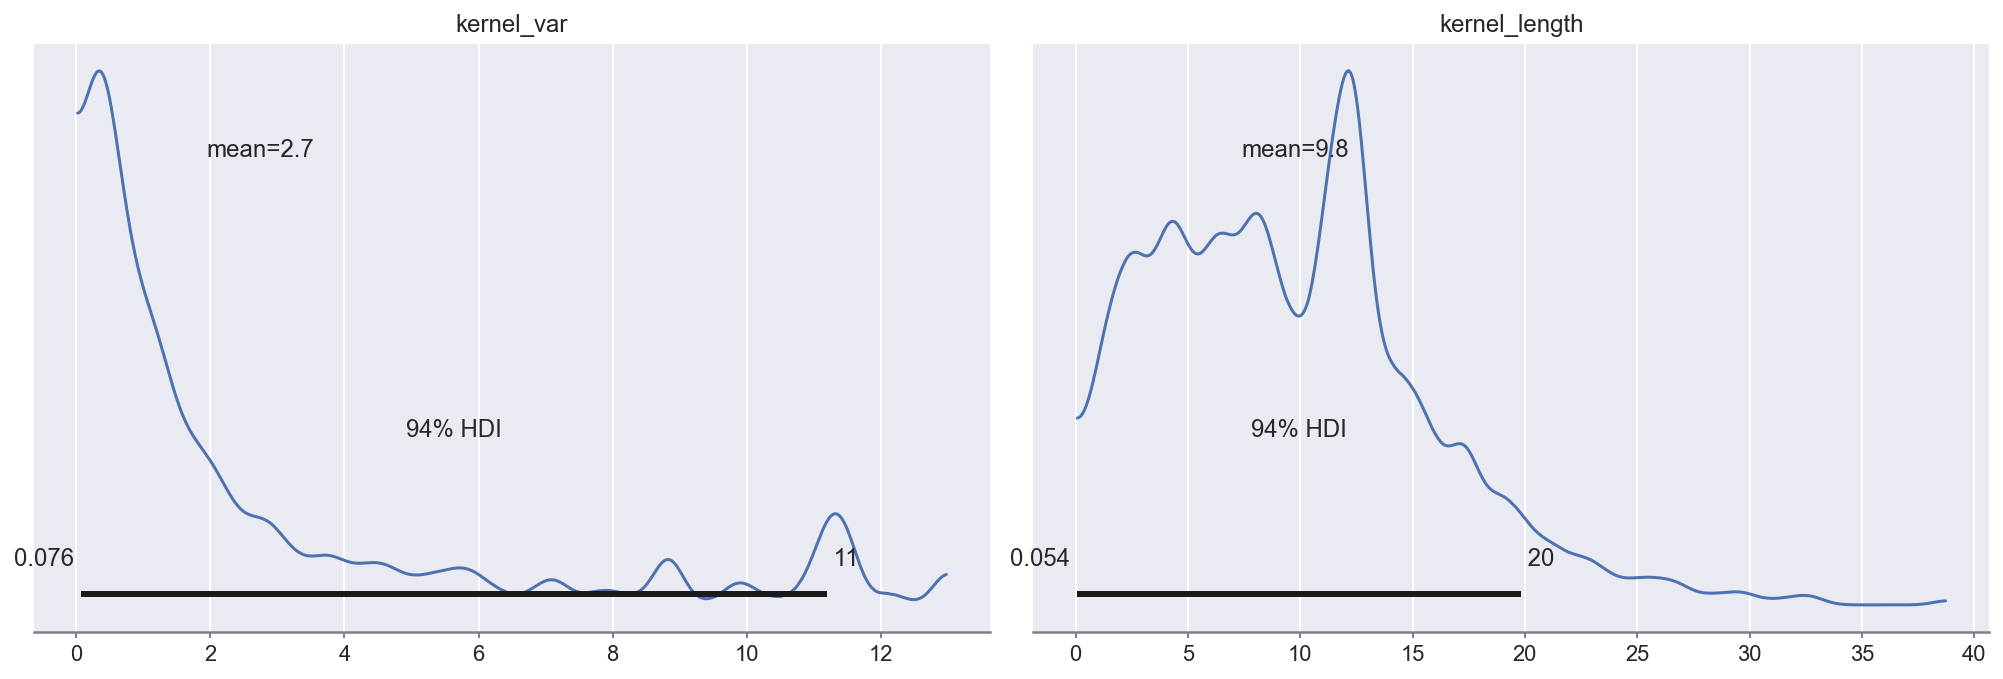

In [70]:
az.plot_posterior(trace, var_names=['kernel_var', 'kernel_length']);

## With 'true' prior

In [71]:
u_model = u_data
theta_model = theta_data
tau_model = tau_data

In [72]:
stan_data = prepare_data_for_stan(data, u=u_model, theta=theta_model, tau=tau_model)

In [73]:
trace = stan_model.sample(data=stan_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

In [74]:
samples_az = az.from_cmdstanpy(trace)

In [75]:
f_samples = gp_predict(X=stan_data["X"], samples_az=samples_az, 
                       u=u_model, theta=theta_model)

100%|██████████| 2000/2000 [00:02<00:00, 683.25it/s]


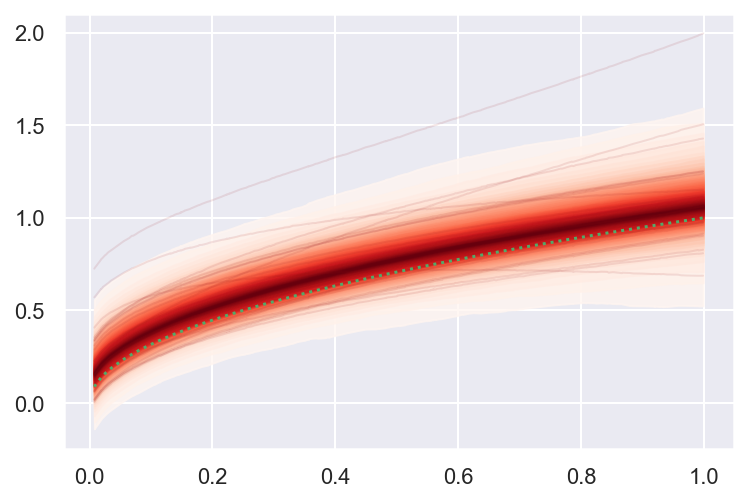

In [76]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, stan_data["X"])
# ax.plot(X, u_model(X, theta=theta_model), ls="--");
ax.plot(stan_data["X"], u_data(stan_data["X"], theta=theta_data), ls=':', color="C2");

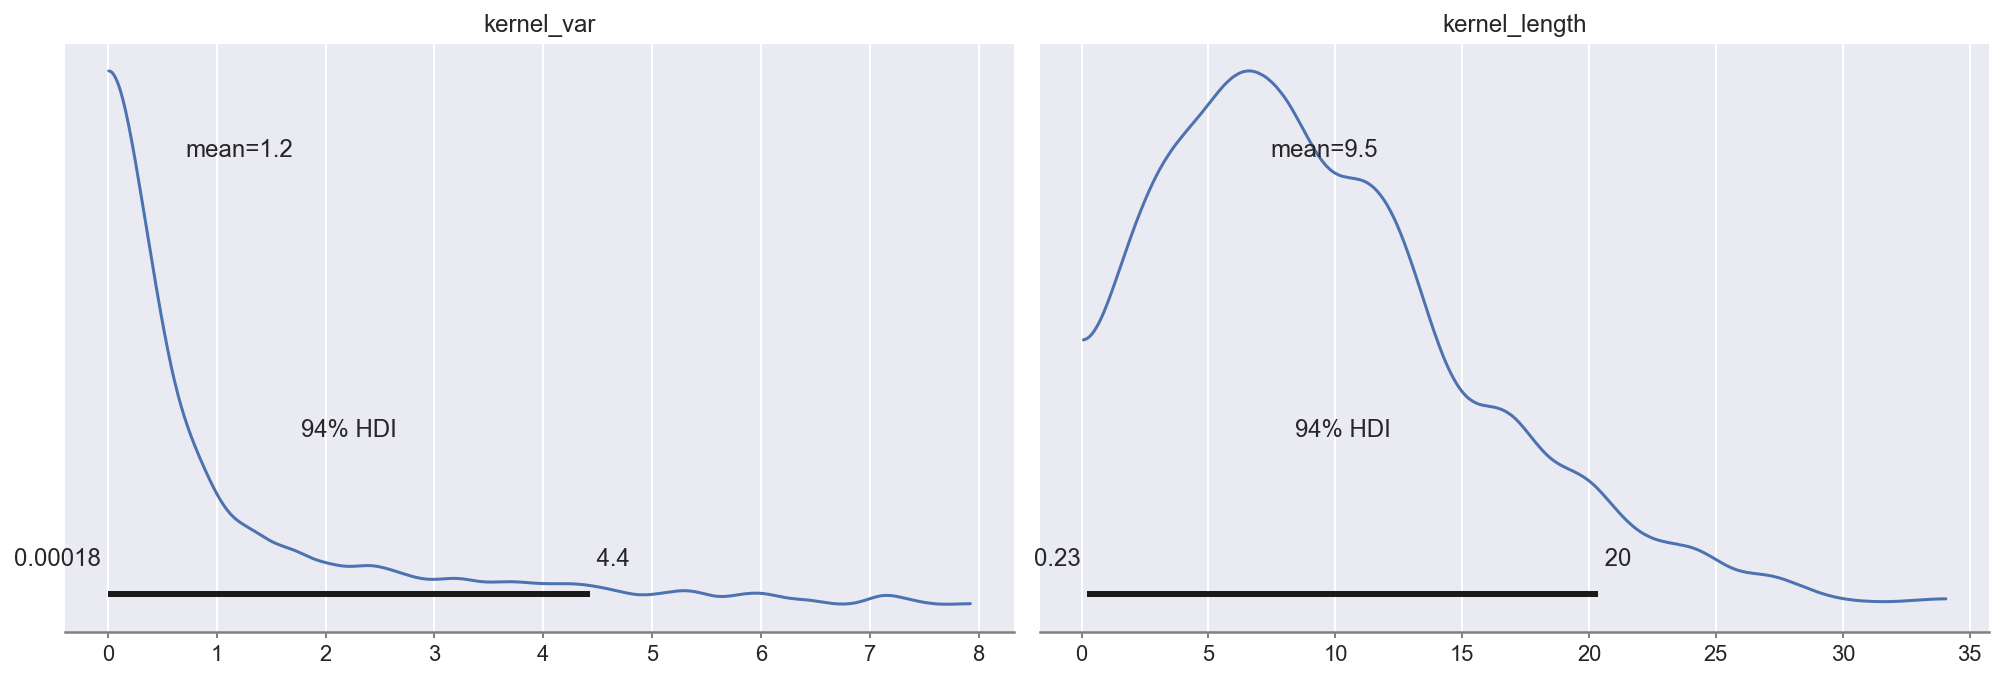

In [77]:
az.plot_posterior(trace, var_names=['kernel_var', 'kernel_length']);

# Sparse

In [78]:
%%stan -f sparse_gp_model_additive.stan -v sparse_model --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
functions {
  vector u_pow(vector x, real theta) {
    return pow(x, theta); 
  }
} 

data {
  int<lower=0> N;
  int<lower=0> N_y;
  vector<lower=0, upper=1>[N] p;
  vector[N] X;
  int<lower=0, upper=1> y[N_y];
  int belong0[N_y];
  int belong1[N_y];
  real theta;
  real tau;
  real jitter;
  int M;
  int<lower=0, upper=1> u_model_index;
}
transformed data {
  matrix[M, M] diag_jitter;
  diag_jitter = diag_matrix(rep_vector(jitter, M));
  real X_array[N];
  X_array = to_array_1d(X);
}
parameters {
  real<lower=0> kernel_length;
  real<lower=0> kernel_var; 
  vector[M] eta;
  vector<lower=0, upper=1>[M] Xm;
}
transformed parameters{
}
model {
  vector[N] seu;
  vector[N_y] seu0;
  vector[N_y] seu1;
  vector[N] Mp;
  vector[N] f_predict;
  vector[N_y] diff_eu;
  matrix[M, M] L;
  matrix[M, M] K;
  vector[M] f;
  matrix[M, N] K_mp;
  vector[M] Mm;
  vector[M] L_dot_eta;
  matrix[M, N] A;
  vector[M] v;
  
  matrix[M, M] K_factor;
  matrix[M, N] K_mp_factor;
  
  real Xm_array[M];
  
  Xm_array = to_array_1d(Xm);
  
  kernel_length ~ normal(1, 1);
  kernel_var ~ normal(1, 1);
  eta ~ std_normal();
  Xm ~ uniform(0, 1);
  
  if (u_model_index == 0) {
    Mm = Xm;
    Mp = X;
  }
  else if (u_model_index == 1) {
    Mm = u_pow(Xm, theta);
    Mp = u_pow(X, theta);
  }
  else {
    reject("u_model_index incorrect", u_model_index);
  }

  K = gp_exp_quad_cov(to_array_1d(Xm), kernel_var, kernel_length) + diag_jitter;
  L = cholesky_decompose(K);

  L_dot_eta = L*eta;
  f = Mm + L_dot_eta;

  K_mp = gp_exp_quad_cov(Xm_array, X_array, kernel_var, kernel_length);
  A = mdivide_left_tri_low(L, K_mp);
  v = mdivide_left_tri_low(L, L_dot_eta);

  f_predict = Mp + A' * v;

  seu = p .* f_predict;
  seu0 = seu[belong0];
  seu1 = seu[belong1];
  diff_eu = seu1 - seu0;
  y ~ bernoulli_logit(tau * diff_eu);
}
generated quantities {
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/605bef7b-345e-4a52-bad7-f8ea0f068f30.cpp sparse_gp_model_additive.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in sparse_model object.
Type sparse_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^
Access model compile output properties
sparse_model.model_file -> Name of stan_file [sparse_gp_model_additive.stan]
sparse_model.model_name -> Name of stan model [sparse_gp_model_additive_model]
sparse_model.model_code -> Model code [functions {   vector ....]


In [79]:
stan_sparse_model = stan.CmdStanModel(stan_file=sparse_model.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/sparse_gp_model_additive
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/CogModelDiscrepancy/sparse_gp_model_additive


In [88]:
def prepare_data_for_stan_sparse(data, tau, u=u_lin, theta=None, M=50):

    try:
        u_model_index = {u_lin: 0, u_pow: 1}[u]
    except KeyError:
        raise ValueError(f"Utility function {u.__name__} not recognized")
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))

    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    N = len(x)
    N_y = len(y)
    belong0 = undo_sorted[:N_y]
    belong1 = undo_sorted[N_y:]

    return {
        'tau': tau,
        'theta': theta if theta is not None else 0,
        'p': p_sorted,
        'X': x_sorted,
        'y': y,
        'N_y': len(y),
        'N': len(x),
        'jitter': 1e-06,
        'belong0': belong0 + 1,
        'belong1': belong1 + 1,
        'M': M,
        'u_model_index': u_model_index
    } 

In [89]:
def kernel(X, Xs, length):
    deltaX = np.power((X[:, None] - Xs) / length, 2.0)
    return np.exp(-0.5 * deltaX)

def sparse_gp_predict(Xnew, samples_az, u, theta, jitter=1.0e-6):
    
    n_sample = samples_az.posterior["kernel_var"].shape[0] * samples_az.posterior["kernel_var"].shape[1]
    
    var_sp = np.array(samples_az.posterior["kernel_var"]).reshape(n_sample, -1)
    length_sp = np.array(samples_az.posterior["kernel_length"]).reshape(n_sample, -1)
    eta_sp = np.array(samples_az.posterior["eta"]).reshape(n_sample, -1)
    Xm_sp = np.array(samples_az.posterior["Xm"]).reshape(n_sample, -1)
    
    N = Xnew.shape[0]
    f_predict = np.zeros((n_sample, N))
    
    for i in tqdm(range(n_sample)):
    
        var = var_sp[i]
        length = length_sp[i]
        eta = eta_sp[i] 
        X = Xm_sp[i]
        
        uX = u(X, theta)
        
        M = X.shape[0]
        
        k_XX = var**2 * kernel(X, X, length) + jitter*np.eye(M)
        L = np.linalg.cholesky(k_XX)
        L_dot_eta = L.dot(eta)
        f = uX + L_dot_eta


        up = u(Xnew, theta)
        
        K_Xp = var**2 * kernel(X, Xnew, length)

        A = scipy.linalg.solve_triangular(L, K_Xp, lower=True)
        v = scipy.linalg.solve_triangular(L, L_dot_eta, lower=True)

        f_predict[i] = up + A.T.dot(v)

    return f_predict

## Using bad prior

In [90]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

In [94]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=300, replace=False)

In [95]:
optimize(data, u_m=u_pow)

array([4.00085189, 0.48760549])

In [96]:
u_model = u_lin
theta_model = None
tau_model = 3.333
stan_sparse_data = prepare_data_for_stan_sparse(
    data, u=u_model, tau=tau_model, theta=theta_model)

In [97]:
print(stan_sparse_data)

{'tau': 3.333, 'theta': 0, 'p': array([7.13049612e-01, 2.94682610e-01, 2.13360135e-01, 6.96388659e-01,
       2.39674709e-01, 3.68187501e-01, 9.39028520e-01, 9.58713388e-01,
       4.11811522e-01, 4.82192570e-01, 9.35318528e-01, 7.89955603e-01,
       8.26199609e-01, 9.70900125e-01, 7.61839962e-01, 6.25649357e-01,
       8.26035969e-01, 9.92566723e-01, 9.29029343e-01, 6.27106978e-01,
       3.89657697e-01, 7.79575295e-01, 1.16939976e-01, 6.76196978e-01,
       8.35170194e-01, 5.30371513e-01, 9.44391669e-01, 7.81620205e-01,
       6.03511521e-01, 5.52782779e-01, 4.11834090e-01, 5.25551803e-01,
       6.64061308e-01, 8.32812900e-01, 9.36731365e-01, 6.64259961e-01,
       9.86216498e-01, 9.28351105e-01, 8.07191759e-01, 7.30990583e-01,
       2.05818664e-01, 4.00934256e-01, 9.57335669e-01, 8.07753322e-01,
       2.09264429e-01, 8.54177587e-01, 8.40722522e-01, 6.25870067e-01,
       7.73370759e-01, 8.03506928e-01, 5.16670590e-01, 5.65179313e-01,
       9.65327161e-01, 9.39149850e-01, 9.8675

In [98]:
trace = stan_sparse_model.sample(data=stan_sparse_data, show_progress="notebook", chains=2)

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
samples_az = az.from_cmdstanpy(trace)

In [ ]:
x_plot = np.linspace(0, 1, 100)
f_samples = sparse_gp_predict(Xnew=x_plot, samples_az=samples_az, 
                              u=u_lin, theta=None)

In [ ]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, x_plot)
ax.plot(x_plot, u_model(x_plot, theta=theta_model), ls="--");
ax.plot(x_plot, u_data(x_plot, theta=theta_data), ls=':', color="C2");

In [ ]:
az.plot_posterior(samples_az, var_names=["kernel_var", "kernel_length"]);

In [ ]:
trace.diagnose()

## Using 'good' prior

In [ ]:
u_data = u_pow
theta_data = 0.5
tau_data = 3.333

In [ ]:
data = generate_data(u=u_data, tau=tau_data, theta=theta_data, n=1000, seed=123)
np.random.seed(12345)
data = data.sample(n=300, replace=False)

In [ ]:
optimize(data, u_m=u_pow)

In [ ]:
u_model = u_data
theta_model = theta_data
tau_model = tau_data
stan_sparse_data = prepare_data_for_stan_sparse(
    data, u=u_model, tau=tau_model, theta=theta_model)

In [ ]:
trace = stan_sparse_model.sample(data=stan_sparse_data, show_progress="notebook", chains=2)

In [ ]:
samples_az = az.from_cmdstanpy(trace)

In [ ]:
x_plot = np.linspace(0, 1, 100)
f_samples = sparse_gp_predict(Xnew=x_plot, samples_az=samples_az, 
                              u=u_model, theta=theta_model,
                              use_ratio=True)

In [ ]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_samples, x_plot)
ax.plot(x_plot, u_model(x_plot, theta=theta_model), ls="--");
ax.plot(x_plot, u_data(x_plot, theta=theta_data), ls=':', color="C2");

In [ ]:
az.plot_posterior(samples_az, var_names=["kernel_var", "kernel_length"]);

In [ ]:
trace.diagnose()